## Sentiment Classification on Large Movie Reviews

[Sentiment Analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) is understood as a classic natural language processing problem. In this example, a large moview review dataset was chosen from IMDB to do a sentiment classification task with some deep learning approaches. The labeled data set consists of 50,000 [IMDB](http://www.imdb.com/) movie reviews (good or bad), in which 25000 highly polar movie reviews for training, and 25,000 for testing. The dataset is originally collected by Stanford researchers and was used in a [2011 paper](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf), and the highest accuray of 88.33% was achieved without using the unbalanced data. This example illustrates some deep learning approaches to do the sentiment classification with [BigDL](https://github.com/intel-analytics/BigDL) python API.

### Load the IMDB Dataset
The IMDB dataset need to be loaded into BigDL, note that the dataset has been pre-processed, and each review was encoded as a sequence of integers. Each integer represents the index of the overall frequency of dataset, for instance, '5' means the 5-th most frequent words occured in the data. It is very convinient to filter the words by some conditions, for example, to filter only the top 5,000 most common word and/or eliminate the top 30 most common words. Let's define functions to load the pre-processed data.

In [1]:
from bigdl.dataset import base
import numpy as np

def download_imdb(dest_dir):
    """Download pre-processed IMDB movie review data

    :argument
        dest_dir: destination directory to store the data

    :return
        The absolute path of the stored data
    """
    file_name = "imdb.npz"
    file_abs_path = base.maybe_download(file_name,
                                        dest_dir,
                                        'https://s3.amazonaws.com/text-datasets/imdb.npz')
    return file_abs_path

def load_imdb(dest_dir='/tmp/.bigdl/dataset'):
    """Load IMDB dataset.

    :argument
        dest_dir: where to cache the data (relative to `~/.bigdl/dataset`).

    :return
        the train, test separated IMDB dataset.
    """
    path = download_imdb(dest_dir)
    f = np.load(path)
    x_train = f['x_train']
    y_train = f['y_train']
    x_test = f['x_test']
    y_test = f['y_test']
    f.close()

    return (x_train, y_train), (x_test, y_test)

print('Processing text dataset')
(x_train, y_train), (x_test, y_test) = load_imdb()
print('finished processing text')

Processing text dataset
finished processing text


In order to set a proper max sequence length, we need to go througth the property of the data and see the length distribution of each sentence in the dataset. A box and whisker plot is shown below for reviewing the length distribution in words.

Review length: 
Mean 233.76 words (172.911495)


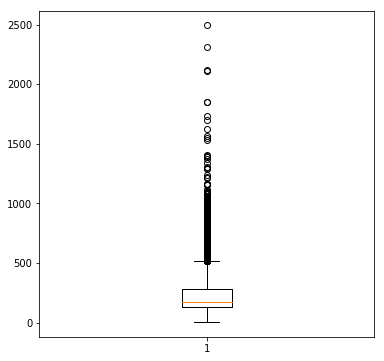

In [2]:
# Summarize review length
from matplotlib import pyplot

print("Review length: ")
X = np.concatenate((x_train, x_test), axis=0)
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
# Create a figure instance
fig = pyplot.figure(1, figsize=(6, 6))
pyplot.boxplot(result)
pyplot.show()

Looking the box and whisker plot, the max length of a sample in words is 500, and the mean and median are below 250. According to the plot, we can probably cover the mass of the distribution with a clipped length of 400 to 500. Here we set the max sequence length of each sample as 500.

The corresponding vocabulary sorted by frequency is also required, for further embedding the words with pre-trained vectors. The downloaded vocabulary is in {word: index}, where each word as a key and the index as a value. It needs to be transformed into {index: word} format.

Let's define a function to obtain the vocabulary.

In [3]:
import json

def get_word_index(dest_dir='/tmp/.bigdl/dataset', ):
    """Retrieves the dictionary mapping word indices back to words.

    :argument
        path: where to cache the data (relative to `~/.bigdl/dataset`).

    :return
        The word index dictionary.
    """
    file_name = "imdb_word_index.json"
    path = base.maybe_download(file_name,
                               dest_dir,
                               source_url='https://s3.amazonaws.com/text-datasets/imdb_word_index.json')
    f = open(path)
    data = json.load(f)
    f.close()
    return data

print('Processing vocabulary')
word_idx = get_word_index()
idx_word = {v:k for k,v in word_idx.items()}
print('finished processing vocabulary')

Processing vocabulary
finished processing vocabulary


### Text pre-processing

Before we train the network, some pre-processing steps need to be applied to the dataset. 

Next let's go through the mechanisms that used to be applied to the data.

* We insert a `start_char` at the beginning of each sentence to mark the start point. We set it as `2` here, and each other word index will plus a constant `index_from` to differentiate some 'helper index' (eg. `start_char`, `oov_char`, etc.).

* A `max_words` variable is defined as the maximum index number (the least frequent word) included in the sequence. If the word index number is larger than `max_words`, it will be replaced by a out-of-vocabulary number `oov_char`, which is `3` here.

* Each word index sequence is restricted to the same length. We used left-padding here, which means the right (end) of the sequence will be keep as many as possible and drop the left (head) of the sequence if its length is more than pre-defined `sequence_len`, or padding the left (head) of the sequence with `padding_value`.

In [4]:
def replace_oov(x, oov_char, max_words):
    """
    Replace the words out of vocabulary with `oov_char`
    :param x: a sequence
    :param max_words: the max number of words to include
    :param oov_char: words out of vocabulary because of exceeding the `max_words`
        limit will be replaced by this character

    :return: The replaced sequence
    """
    return [oov_char if w >= max_words else w for w in x]

def pad_sequence(x, fill_value, length):
    """
    Pads each sequence to the same length
    :param x: a sequence
    :param fill_value: pad the sequence with this value
    :param length: pad sequence to the length

    :return: the padded sequence
    """
    if len(x) >= length:
        return x[(len(x) - length):]
    else:
        return [fill_value] * (length - len(x)) + x

def to_sample(features, label):
    """
    Wrap the `features` and `label` to a training sample object
    :param features: features of a sample
    :param label: label of a sample
    
    :return: a sample object including features and label
    """
    return Sample.from_ndarray(np.array(features, dtype='float'), np.array(label))

padding_value = 1
start_char = 2
oov_char = 3
index_from = 3
max_words = 5000
sequence_len = 500

print('start transformation')

train_rdd = sc.parallelize(zip(x_train, y_train), 2) \
        .map(lambda (x, y): ([start_char] + [w + index_from for w in x] , y))\
        .map(lambda (x, y): (replace_oov(x, oov_char, max_words), y))\
        .map(lambda (x, y): (pad_sequence(x, padding_value, sequence_len), y))\
        .map(lambda (x, y): to_sample(x, y))
test_rdd = sc.parallelize(zip(x_test, y_test), 2) \
        .map(lambda (x, y): ([start_char] + [w + index_from for w in x], y))\
        .map(lambda (x, y): (replace_oov(x, oov_char, max_words), y))\
        .map(lambda (x, y): (pad_sequence(x, padding_value, sequence_len), y))\
        .map(lambda (x, y): to_sample(x, y))
        
print('finish transformation')

start transformation
finish transformation


### Word Embedding

[Word embedding](https://en.wikipedia.org/wiki/Word_embedding) is a recent breakthrough in natural language field. The key idea is to encode words and phrases into distributed representations in the format of word vectors, which means each word is represented as a vector. There are two widely used word vector training alogirhms, one is published by Google called [word to vector](https://arxiv.org/abs/1310.4546), the other is published by Standford called [Glove](https://nlp.stanford.edu/projects/glove/). In this example, pre-trained glove is loaded into a lookup table and will be fine-tuned during the training process. BigDL provides a method to download and load glove in `news20` package.

In [5]:
from bigdl.dataset import news20
import itertools

embedding_dim = 100

print('loading glove')
glove = news20.get_glove_w2v(source_dir='/tmp/.bigdl/dataset', dim=embedding_dim)
print('finish loading glove')

loading glove
finish loading glove


For each word whose index less than the `max_word` should try to match its embedding and store in an array.

With regard to those words which can not be found in glove, we randomly sample it from a [-0.05, 0.05] uniform distribution.

BigDL usually use a `LookupTable` layer to do word embedding, so the matrix will be loaded to the LookupTable by seting the weight.

In [6]:
print('processing glove')
w2v = [glove.get(idx_word.get(i - index_from), np.random.uniform(-0.05, 0.05, embedding_dim))
        for i in xrange(1, max_words + 1)]
w2v = np.array(list(itertools.chain(*np.array(w2v, dtype='float'))), dtype='float') \
        .reshape([max_words, embedding_dim])
print('finish processing glove')

processing glove
finish processing glove


### Build models

Next, let's build some deep learning models for the sentiment classification. 

As an example, several deep learning models are illustrated for tutorial, comparison and demonstration.

**LSTM**, **GRU**, **Bi-LSTM**, **CNN** and **CNN + LSTM** models are implemented as options. To decide which model to use, just assign model_type the corresponding string.

In [7]:
from bigdl.nn.layer import *
from bigdl.util.common import *

p = 0.2

def build_model(w2v):
    model = Sequential()

    embedding = LookupTable(max_words, embedding_dim)
    embedding.set_weights([w2v])
    model.add(embedding)
    if model_type.lower() == "gru":
        model.add(Recurrent()
                .add(GRU(embedding_dim, 128, p))) \
            .add(Select(2, -1))
    elif model_type.lower() == "lstm":
        model.add(Recurrent()
                  .add(LSTM(embedding_dim, 128, p)))\
            .add(Select(2, -1))
    elif model_type.lower() == "bi_lstm":
        model.add(BiRecurrent(CAddTable())
                  .add(LSTM(embedding_dim, 128, p)))\
            .add(Select(2, -1))
    elif model_type.lower() == "cnn":
        model.add(Transpose([(2, 3)]))\
            .add(Dropout(p))\
            .add(Reshape([embedding_dim, 1, sequence_len]))\
            .add(SpatialConvolution(embedding_dim, 128, 5, 1))\
            .add(ReLU())\
            .add(SpatialMaxPooling(sequence_len - 5 + 1, 1, 1, 1))\
            .add(Reshape([128]))
    elif model_type.lower() == "cnn_lstm":
        model.add(Transpose([(2, 3)]))\
            .add(Dropout(p))\
            .add(Reshape([embedding_dim, 1, sequence_len])) \
            .add(SpatialConvolution(embedding_dim, 64, 5, 1)) \
            .add(ReLU()) \
            .add(SpatialMaxPooling(4, 1, 1, 1)) \
            .add(Squeeze(3)) \
            .add(Transpose([(2, 3)])) \
            .add(Recurrent()
                 .add(LSTM(64, 128, p))) \
            .add(Select(2, -1))

    model.add(Linear(128, 100))\
        .add(Dropout(0.2))\
        .add(ReLU())\
        .add(Linear(100, 1))\
        .add(Sigmoid())

    return model

### Optimization
`Optimizer` need to be created to optimise the model.

Here we use the `CNN` model.

More details about optimizer in BigDL, please refer to [Programming Guide](https://github.com/intel-analytics/BigDL/wiki/Programming-Guide#optimizer).

In [8]:
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *

max_epoch = 4
batch_size = 64
model_type = 'gru'

init_engine()

optimizer = Optimizer(
        model=build_model(w2v),
        training_rdd=train_rdd,
        criterion=BCECriterion(),
        end_trigger=MaxEpoch(max_epoch),
        batch_size=batch_size,
        optim_method=Adam())

optimizer.set_validation(
        batch_size=batch_size,
        val_rdd=test_rdd,
        trigger=EveryEpoch(),
        val_method=Top1Accuracy())

creating: createSequential
creating: createLookupTable
creating: createRecurrent
creating: createGRU
creating: createSelect
creating: createLinear
creating: createDropout
creating: createReLU
creating: createLinear
creating: createSigmoid
creating: createBCECriterion
creating: createMaxEpoch
creating: createAdam
creating: createOptimizer
creating: createEveryEpoch


To make the training process be visualized by TensorBoard, training summaries should be saved as a format of logs.

With regard to the usage of TensorBoard in BigDL, please refer to [BigDL Wiki](https://github.com/intel-analytics/BigDL/wiki/Visualization-with-TensorBoard).

In [9]:
import datetime as dt

logdir = '/tmp/.bigdl/'
app_name = 'adam-' + dt.datetime.now().strftime("%Y%m%d-%H%M%S")

train_summary = TrainSummary(log_dir=logdir, app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir=logdir, app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)

creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary


Now, let's start training!

In [10]:
%%time
train_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 196 ms, sys: 24 ms, total: 220 ms
Wall time: 51min 52s


### Test
Validation accuracy is shown in the training log, here let's get the accuracy on validation set by hand.

Predict the `test_rdd` (validation set data), and obtain the predicted label and ground truth label in the list.

In [11]:
predictions = train_model.predict(test_rdd)

def map_predict_label(l):
    if l > 0.5:
        return 1
    else:
        return 0
def map_groundtruth_label(l):
    return l[0]

y_pred = np.array([ map_predict_label(s) for s in predictions.collect()])

y_true = np.array([map_groundtruth_label(s.label) for s in test_rdd.collect()])

Then let's see the prediction accuracy on validation set.

In [12]:
correct = 0
for i in xrange(0, y_pred.size):
    if (y_pred[i] == y_true[i]):
        correct += 1

accuracy = float(correct) / y_pred.size
print 'Prediction accuracy on validation set is: ', accuracy

Prediction accuracy on validation set is:  0.89312


Show the confusion matrix

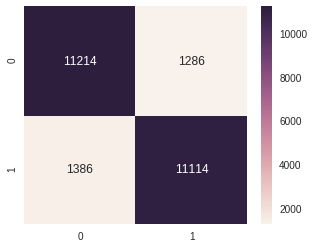

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm.shape

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (5,4))
sn.heatmap(df_cm, annot=True,fmt='d')

Because of the limitation of ariticle length, not all the results of optional models can be shown respectively. Please try other provided optional models to see the results. If you are interested in optimizing the results, try different training parameters which may make inpacts on the result, such as the max sequence length, batch size, training epochs, preprocessing schemes, optimization methods and so on. Among the models, CNN training would be much quicker. Note that the LSTM and it variants (eg. GRU) are difficult to train, even a unsuitable batch size may cause the model not converge. In addition it is prone to overfitting, please try different dropout threshold and/or add regularizers (abouth how to add regularizers in BigDL please see [BigDL Wiki](https://github.com/intel-analytics/BigDL/wiki/Programming-Guide#regularizers)).

### Summary
In this example, you learned how to use BigDL to develop deep learning models for sentiment analysis including:

* How to load and review the IMDB dataset
* How to do word embedding with Glove
* How to build a CNN model for NLP with BigDL
* How to build a LSTM model for NLP with BigDL
* How to build a GRU model for NLP with BigDL
* How to build a Bi-LSTM model for NLP with BigDL
* How to build a CNN-LSTM model for NLP with BigDL
* How to train deep learning models with BigDL

Thanks for your reading, please enjoy the trip on using BigDL to build deep learning models.